In [2]:
#! /usr/bin/env python

from __future__ import print_function
import os
import numpy as np
#from read_psf_cats import read_data, band_combinations
import fitsio
import treecorr
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from astropy.io import fits

In [17]:
prefix='piff' #'psfex'

#reserve stars catalogue with Piff solutions
data = fitsio.read('/global/homes/m/mjarvis/desdata/users/mjarvis/y3a1-v29/psf_y3a1-v29.fits')
#h = fitsio.read_header('/global/homes/m/mjarvis/desdata/users/mjarvis/y3a1-v29/psf_y3a1-v29.fits')
#print(h)
band=data['band']
print(np.shape(data))
data=data[np.where((band == 'r') | (band == 'i') | (band == 'z') )] #| (band == 'g')) ]
#print(data[:100])
data = data[data['ra'].argsort()]#[:10000]
#print(data)
print(len(data))
rastarcat = data['ra']
decstarcat = data['dec'] 
rastarcat[rastarcat > 180] -= 360
#data=data[np.where(rastarcat>-40)]
#rastarcat = rastarcat[np.where(rastarcat>-40)]
#decstarcat = decstarcat[np.where(rastarcat>-40)]
print(min(data['ra']))
print(len(data))
print(type(data))

print(data)


(56707987,)
38137671
-61.9685320641
38137671
<type 'numpy.ndarray'>
[ (  3.88902716e-06, -37.05185456,  1686.5288077 ,  1496.62491822, -0.05416345, -0.01405471,  0.2216893 , -0.04722466, -0.01642145,  0.24054351,  20.53555298, -2493.83732358, -1825.31864651, 386640,  4, 'z', 0)
 (  3.89533041e-05,  -2.41734978,  1717.85717519,   542.75516931,  0.01641352,  0.02661008,  0.47625814,  0.01935986,  0.02531338,  0.47644888,  18.63895226,  1664.75243707,  1284.42760953, 251797, 49, 'r', 0)
 (  5.47103130e-05,  -2.92039452,  1864.9216464 ,  2695.68822803, -0.05126323,  0.02683974,  0.5384173 , -0.04296035,  0.03687792,  0.51865239,  17.34756088,  3482.151993  ,  1290.54667064, 251798, 62, 'i', 0)
 ...,
 ( -2.78833683e-05, -59.64632164,   498.74058908,    47.25702274, -0.02084245, -0.02477175,  0.32561721, -0.02484744, -0.03174512,  0.3244623 ,  17.05013084,  2529.93917493, -2206.50240302, 504500, 56, 'z', 0)
 ( -1.03070254e-05, -54.76289575,   680.74910677,  2823.19287518, -0.00975337,  0.025

In [18]:
def compute_res(d):

    de1 =  d['obs_e1']-d[prefix+'_e1']
    de2 =  d['obs_e2']-d[prefix+'_e2']
    dt =  (d['obs_T']-d[prefix+'_T'])
    dtfrac = dt/d['obs_T']
    print('mean de = ',np.mean(de1),np.mean(de2))
    print('mean dt = ',np.mean(dt))

    return dtfrac, dt,  de1, de2

In [11]:
def compute_res(d):

    de1 =  d['obs_e1']-d[prefix+'_e1']
    de2 =  d['obs_e2']-d[prefix+'_e2']
    dt =  (d['obs_T']-d[prefix+'_T'])
    dtfrac = dt/d['obs_T']
    print(de1)
    print(d['obs_T'])
    de1frac=de1/d['obs_e1']
    de2frac=de2/d['obs_e2']
    print(de1frac)
    print(de2frac)
    #for k in range(len(tile_data)):
    #print('k = ',k)
    print('mean de = ',np.mean(de1),np.mean(de2))
    print('mean dt = ',np.mean(dt))
    print('mean de frac = ',np.mean(de1frac),np.mean(de2frac))
    print('mean dt frac = ',np.mean(dtfrac))    
    print(len(de1frac))
    print(len(de1frac[np.where(np.isnan(de1frac)==True)]))
          
    fig, axes = plt.subplots(1,3, sharex=False, sharey=True)
    
    ax = axes[0]
    ax.hist(dtfrac)
    ax.set_xlabel(r'$(T_{\rm PSF} - T_{\rm model})/ T_{\rm PSF}$', fontsize='x-large')
    #plt.title('riz-only')
    
    ax = axes[1]
    ax.hist(de1frac,range=(-1,1))
    ax.set_xlabel(r'$(e1_{\rm PSF} - e1_{\rm model})$', fontsize='x-large')
    ax.set_title('g-only')
    
    ax = axes[2]
    ax.hist(de2frac,range=(-1,1))
    ax.set_xlabel(r'$(e2_{\rm PSF} - e2_{\rm model})$', fontsize='x-large')
    #plt.title('riz-only')
    fig.set_size_inches(10.0,4.0)
    plt.tight_layout()

    return dtfrac, dt,  de1, de2


In [20]:
fracsizeres, sizeres, e1res, e2res=compute_res(data)

mean de =  3.33824725402e-05 -4.07063973377e-05
mean dt =  -0.000128128844727


In [25]:
#want psf vs mag- brighter vs fatter
def bin_by_mag(m, dT, dTfrac, de1, de2, min_mused):
    min_mag = 15 # 15
    max_mag = 21 #21
     
    mag_bins = np.linspace(min_mag,max_mag,31)
    #print('mag_bins = ',mag_bins)

    index = np.digitize(m, mag_bins)
    #print('len(index) = ',len(index))
    bin_de1 = [de1[index == i].mean() for i in range(1, len(mag_bins))]
    #print('bin_de1 = ',bin_de1)
    bin_de2 = [de2[index == i].mean() for i in range(1, len(mag_bins))]
    #print('bin_de2 = ',bin_de2)
    bin_dT = [dT[index == i].mean() for i in range(1, len(mag_bins))]
    #print('bin_dT = ',bin_dT)
    bin_dTfrac = [dTfrac[index == i].mean() for i in range(1, len(mag_bins))]
    #print('bin_dTfrac = ',bin_dTfrac)
    bin_de1_err = [ np.sqrt(de1[index == i].var() / len(de1[index == i]))
                    for i in range(1, len(mag_bins)) ]
    #print('bin_de1_err = ',bin_de1_err)
    bin_de2_err = [ np.sqrt(de2[index == i].var() / len(de2[index == i]))
                    for i in range(1, len(mag_bins)) ]
    #print('bin_de2_err = ',bin_de2_err)
    bin_dT_err = [ np.sqrt(dT[index == i].var() / len(dT[index == i]))
                    for i in range(1, len(mag_bins)) ]
    #print('bin_dT_err = ',bin_dT_err)
    bin_dTfrac_err = [ np.sqrt(dTfrac[index == i].var() / len(dTfrac[index == i]))
                    for i in range(1, len(mag_bins)) ]
    #print('bin_dTfrac_err = ',bin_dTfrac_err)
    #for i in range(1, len(mag_bins)):
        #print('len(index) = ',len(de1[index == i]))
    # Fix up nans
    for i in range(1,len(mag_bins)):
        if i not in index:
            bin_de1[i-1] = 0.
            bin_de2[i-1] = 0.
            bin_dT[i-1] = 0.
            bin_dTfrac[i-1] = 0.
            bin_de1_err[i-1] = 0.
            bin_de2_err[i-1] = 0.
            bin_dT_err[i-1] = 0.
            bin_dTfrac_err[i-1] = 0.
    #print('fixed nans')
    #print('index = ',index)
    #print('bin_de1 = ',bin_de1)
    #print('bin_de2 = ',bin_de2)
    #print('bin_dT = ',bin_dT)
    
    fit = np.polyfit(mag_bins[:-1], bin_dT, 3)
    fit_fn = np.poly1d(fit) 
    # fit_fn is now a function which takes in x and returns an estimate for y

    
    fig, axes = plt.subplots(3,1, sharex=True)
    min_mag=15
    max_mag=21
    min_mused=16.5

    ax = axes[0]
    ax.set_ylim(-0.003,0.003)
    ax.plot([min_mag,max_mag], [0,0], color='black')
    ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
    t_line = ax.errorbar(mag_bins[:-1], bin_dT, yerr=bin_dT_err, color='blue', fmt='o',label="all")
    ax.set_ylabel(r'$(T_{\rm PSF} - T_{\rm model}) \quad({\rm arcsec}^2)$', fontsize='xx-large')

    ax = axes[1]
    ax.set_ylim(-0.005,0.005)
    ax.plot([min_mag,max_mag], [0,0], color='black')
    ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
    t_line = ax.errorbar(mag_bins[:-1], bin_dTfrac, yerr=bin_dTfrac_err, color='blue', fmt='o')
    ax.set_ylabel(r'$(T_{\rm PSF} - T_{\rm model})/ T_{\rm PSF}$', fontsize='xx-large')

    ax = axes[2]
    ax.set_ylim(-5.e-4,5.e-4)
    ax.plot([min_mag,max_mag], [0,0], color='black')
    ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
    e1_line = ax.errorbar(mag_bins[:-1], bin_de1, yerr=bin_de1_err,  color='red', fmt='o', mfc='white',label=r"$\rm{Y3 \quad e_1}$")
    e2_line = ax.errorbar(mag_bins[:-1], bin_de2, yerr=bin_de2_err, color='blue', fmt='o',label=r"$\rm{Y3 \quad e_2}$")
    ax.legend(loc='lower left')
    ax.set_ylabel(r'$e_{\rm PSF} - e_{\rm model}$', fontsize='xx-large')
    ax.set_xlim(min_mag,max_mag)
    ax.set_xlabel(r'$\rm{Magnitude}$', fontsize='xx-large')
    

    #plt.hist(meddt["Ks"], 30,range=(-0.004,0.002),color="purple",label="Ks",histtype='step')
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['mathtext.fontset'] = 'stix'

    fig.set_size_inches(7.0,12.0)
    plt.tight_layout()
    plt.savefig('dpsf_mag_nocolsplits.pdf')
    plt.show()


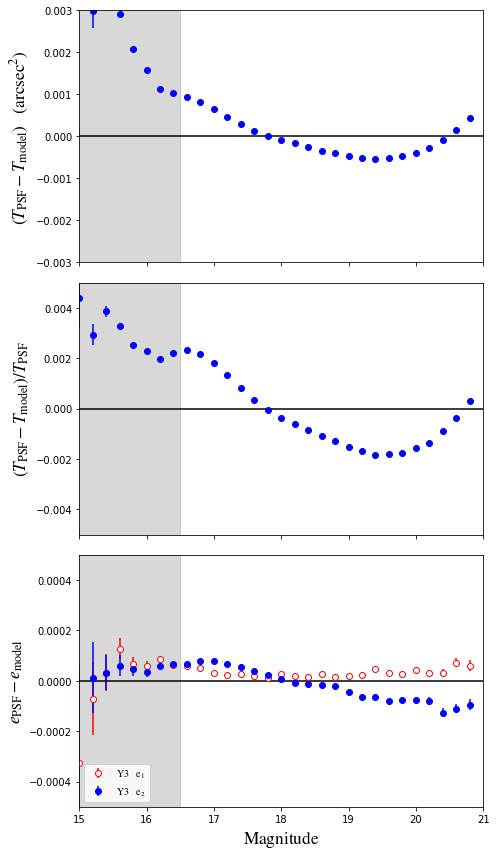

In [26]:
bin_by_mag(data['mag'], sizeres, fracsizeres, e1res, e2res, 16.5)

In [62]:
#Y1 DATA

#reserve stars catalogue with Piff solutions
dataY1 = fitsio.read('/global/cscratch1/sd/aamon/psf_y1a1-v13.fits')
magdataY1 = fitsio.read('/global/cscratch1/sd/aamon/psf_y1a1-v13_mag.fits')
#h = fitsio.read_header('psf_y1a1-v13.fits')
print(magdataY1.dtype)
bandY1=dataY1['filter']
print(np.shape(dataY1))
#dataY1=np.column_stack((dataY1,magdataY1['mag']))
#print(np.shape(dataY1))
#mask=np.where((bandY1 == 'r') | (bandY1 == 'i') | (bandY1 == 'z') )
#dataY1=dataY1[mask] #| (band == 'g')) ]
#magdataY1=magdataY1[mask]
#dataY1 = dataY1[dataY1['ra'].argsort()]#[:10000]

print(min(dataY1['ra']))
print(len(dataY1))
print(type(dataY1))
print(dataY1)


[('mag', '>f8')]
(14468770,)
-61.9807472229
14468770
<type 'numpy.ndarray'>
[ (-35.08337402, -51.49461746,  1385.08886719,   289.10256958, -0.02611214, -0.01467164,  0.49505737, -0.01641884,  0.00725295,  0.4982172 ,  228725.,   1., -3166.02323061, -1582.79469488, 'g', 4)
 (-35.07847595, -51.47761917,  1151.42773438,   327.70162964, -0.02605871,  0.01991907,  0.50882196, -0.01618173,  0.00819806,  0.49870983,  228725.,   1., -3227.47611121, -1572.6431374 , 'g', 4)
 (-35.06253052, -51.52221298,  1761.66442871,   471.93869019, -0.0125359 ,  0.00453706,  0.50179547, -0.01815333,  0.00487672,  0.50000423,  228725.,   1., -3066.983882  , -1534.7087955 , 'g', 4)
 ...,
 ( 89.40039825, -40.7200737 ,  1508.06188965,  3817.70703125, -0.0570276 ,  0.06596171,  0.3730301 , -0.04524649,  0.03728307,  0.36104339,  283856.,  62.,  3388.29786761,  1585.63762391, 'z', 3)
 ( 89.33240509, -40.66453171,   740.63635254,  3115.56958008, -0.02036899,  0.05031853,  0.34564656, -0.02598967,  0.02943574,  0.347

In [63]:
print(min(magdataY1))

( 20.448349,)


/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error
  """Entry point for launching an IPython kernel.


In [64]:
def compute_res_Y1(d):
    prefix='psf'
    de1 =  d['e1']-d[prefix+'_e1']
    de2 =  d['e2']-d[prefix+'_e2']
    d['size'] = 2*d['size']**2.
    d[prefix+'_size'] = 2*d[prefix+'_size']**2.
    dt =  (d['size']-d[prefix+'_size'])
    dtfrac = dt/d['size']
    print('mean de = ',np.mean(de1),np.mean(de2))
    print('mean dt = ',np.mean(dt))

    return dtfrac, dt,  de1, de2

fracsizeresY1, sizeresY1, e1resY1, e2resY1=compute_res_Y1(dataY1)

mean de =  0.000220315084707 -5.18434254539e-05
mean dt =  0.00151620985131


In [46]:
#want psf vs mag- brighter vs fatter
#def bin_by_mag(m, dT, dTfrac, de1, de2, min_mused):
#bin_by_mag(data['mag'], sizeres, fracsizeres, e1res, e2res, 16.5)
    
#bin_by_mag(data['mag'], sizeres, fracsizeres, e1res, e2res, 16.5)
#def bin_by_mag(m, dT, dTfrac, de1, de2, min_mused):
min_mag = 15 # 15
max_mag = 21 #21
min_mused=16.5
mag_bins = np.linspace(min_mag,max_mag,31)
#print('mag_bins = ',mag_bins)

###########################
index = np.digitize(magdataY1['mag'], mag_bins)
bin_de1Y1 = [e1resY1[index == i].mean() for i in range(1, len(mag_bins))]
bin_de2Y1 = [e2resY1[index == i].mean() for i in range(1, len(mag_bins))]
bin_dTY1 = [sizeresY1[index == i].mean() for i in range(1, len(mag_bins))]
bin_dTfracY1 = [fracsizeresY1[index == i].mean() for i in range(1, len(mag_bins))]

bin_de1_errY1 = [ np.sqrt(e1resY1[index == i].var() / len(e1resY1[index == i]))
                for i in range(1, len(mag_bins)) ]
bin_de2_errY1 = [ np.sqrt(e2resY1[index == i].var() / len(e2resY1[index == i]))
                for i in range(1, len(mag_bins)) ]
bin_dT_errY1 = [ np.sqrt(sizeresY1[index == i].var() / len(sizeresY1[index == i]))
                for i in range(1, len(mag_bins)) ]
bin_dTfrac_errY1 = [ np.sqrt(fracsizeresY1[index == i].var() / len(fracsizeresY1[index == i]))
                for i in range(1, len(mag_bins)) ]

#########################
index = np.digitize(data['mag'], mag_bins)
bin_de1 = [e1res[index == i].mean() for i in range(1, len(mag_bins))]
bin_de2 = [e2res[index == i].mean() for i in range(1, len(mag_bins))]
bin_dT = [sizeres[index == i].mean() for i in range(1, len(mag_bins))]
bin_dTfrac = [fracsizeres[index == i].mean() for i in range(1, len(mag_bins))]

bin_de1_err = [ np.sqrt(e1res[index == i].var() / len(e1res[index == i]))
                for i in range(1, len(mag_bins)) ]
bin_de2_err = [ np.sqrt(e2res[index == i].var() / len(e2res[index == i]))
                for i in range(1, len(mag_bins)) ]
bin_dT_err = [ np.sqrt(sizeres[index == i].var() / len(sizeres[index == i]))
                for i in range(1, len(mag_bins)) ]
bin_dTfrac_err = [ np.sqrt(fracsizeres[index == i].var() / len(fracsizeres[index == i]))
                for i in range(1, len(mag_bins)) ]
#########################

#for i in range(1, len(mag_bins)):
    #print('len(index) = ',len(de1[index == i]))
# Fix up nans
for i in range(1,len(mag_bins)):
    if i not in index:
        bin_de1[i-1] = 0.
        bin_de2[i-1] = 0.
        bin_dT[i-1] = 0.
        bin_dTfrac[i-1] = 0.
        bin_de1_err[i-1] = 0.
        bin_de2_err[i-1] = 0.
        bin_dT_err[i-1] = 0.
        bin_dTfrac_err[i-1] = 0.

#fit = np.polyfit(mag_bins[:-1], bin_dT, 3)
#fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

for i in range(1,len(mag_bins)):
    if i not in index:
        bin_de1Y1[i-1] = 0.
        bin_de2Y1[i-1] = 0.
        bin_dTY1[i-1] = 0.
        bin_dTfracY1[i-1] = 0.
        bin_de1_errY1[i-1] = 0.
        bin_de2_errY1[i-1] = 0.
        bin_dT_errY1[i-1] = 0.
        bin_dTfrac_errY1[i-1] = 0.

/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice.
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Degrees of freedom <= 0 for slice
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Degrees of freedom <= 0 for slice
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Degrees of freedom <= 0

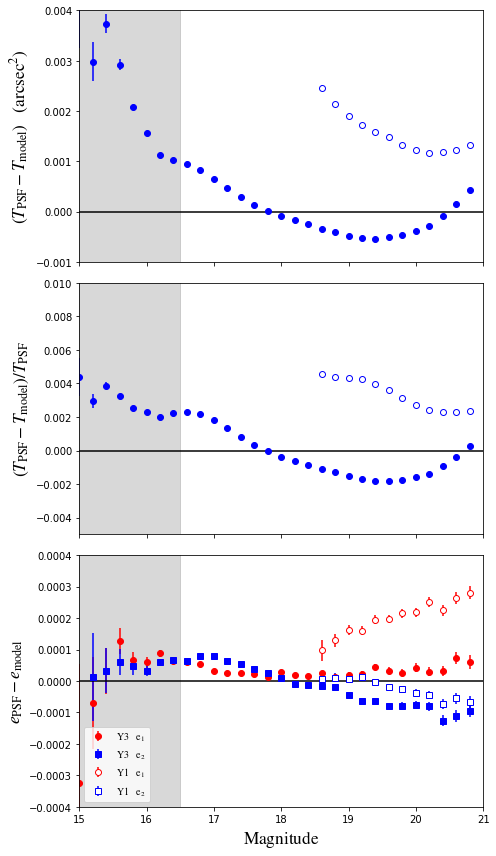

In [59]:
fig, axes = plt.subplots(3,1, sharex=True)
min_mag=15
max_mag=21
min_mused=16.5

ax = axes[0]
ax.set_ylim(-0.001,0.004)
#ax.set_ylim(-0.003,0.003)
ax.plot([min_mag,max_mag], [0,0], color='black')
ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
t_line = ax.errorbar(mag_bins[:-1], bin_dT, yerr=bin_dT_err, color='blue', fmt='o',label="all")
t_lineY1 = ax.errorbar(mag_bins[18:-1], bin_dTY1[18:], yerr=bin_dT_errY1[18:], color='blue', fmt='o',label="all", mfc='white')
ax.set_ylabel(r'$(T_{\rm PSF} - T_{\rm model}) \quad({\rm arcsec}^2)$', fontsize='xx-large')

ax = axes[1]
ax.set_ylim(-0.005,0.01)
ax.plot([min_mag,max_mag], [0,0], color='black')
ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
t_line = ax.errorbar(mag_bins[:-1], bin_dTfrac, yerr=bin_dTfrac_err, color='blue', fmt='o')
t_lineY1 = ax.errorbar(mag_bins[18:-1], bin_dTfracY1[18:], yerr=bin_dTfrac_errY1[18:], color='blue', fmt='o', mfc='white')
ax.set_ylabel(r'$(T_{\rm PSF} - T_{\rm model})/ T_{\rm PSF}$', fontsize='xx-large')

ax = axes[2]
#ax.set_ylim(-5.e-4,5.e-4)
ax.set_ylim(-4.e-4,0.0004)
ax.plot([min_mag,max_mag], [0,0], color='black')
ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
e1_line = ax.errorbar(mag_bins[:-1], bin_de1, yerr=bin_de1_err,  color='red', fmt='o',label=r"$\rm{Y3 \quad e_1}$")
e2_line = ax.errorbar(mag_bins[:-1], bin_de2, yerr=bin_de2_err, color='blue', fmt='s',label=r"$\rm{Y3 \quad e_2}$")

e1_lineY1 = ax.errorbar(mag_bins[18:-1], bin_de1Y1[18:], yerr=bin_de1_errY1[18:],  color='red', fmt='o', mfc='white',label=r"$\rm{Y1 \quad e_1}$")
e2_lineY1 = ax.errorbar(mag_bins[18:-1], bin_de2Y1[18:], yerr=bin_de2_errY1[18:], color='blue', fmt='s', mfc='white',label=r"$\rm{Y1 \quad e_2}$")
ax.legend(loc='lower left')
ax.set_ylabel(r'$e_{\rm PSF} - e_{\rm model}$', fontsize='xx-large')
ax.set_xlim(min_mag,max_mag)
ax.set_xlabel(r'$\rm{Magnitude}$', fontsize='xx-large')


#plt.hist(meddt["Ks"], 30,range=(-0.004,0.002),color="purple",label="Ks",histtype='step')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'

fig.set_size_inches(7.0,12.0)
plt.tight_layout()
plt.savefig('dpsf_mag_nocolsplits.pdf')
plt.show()